In this file I'll do the analysis of the data I collected on Orfeo regarding the MPI broadcast collective operation: in particular, the focus of the analysis will be on the average latency of the operation.

In [11]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import statsmodels.api as sm

In [12]:
# Import the data collected on Orfeo
bcast_default = pd.read_csv("./Results/bcast_default.csv")
bcast_basiclinear = pd.read_csv("./Results/bcast_basiclinear.csv")
bcast_binarytree = pd.read_csv("./Results/bcast_binarytree.csv")
bcast_chain = pd.read_csv("./Results/bcast_chain.csv")

# Bind the data together in a single dataframe
bcast_results = pd.concat([bcast_default, bcast_basiclinear, bcast_binarytree, bcast_chain])

# Remove the rows containing # on the MessageSize column (invalid data)
bcast_results = bcast_results[bcast_results.MessageSize != '#']

# Convert the MessageSize, Processes and Latency columns to int
bcast_results["MessageSize"] = bcast_results["MessageSize"].astype(int)
bcast_results["Processes"] = bcast_results["Processes"].astype(int)
bcast_results["Latency"] = bcast_results["Latency"].astype(float)

/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3669495118.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


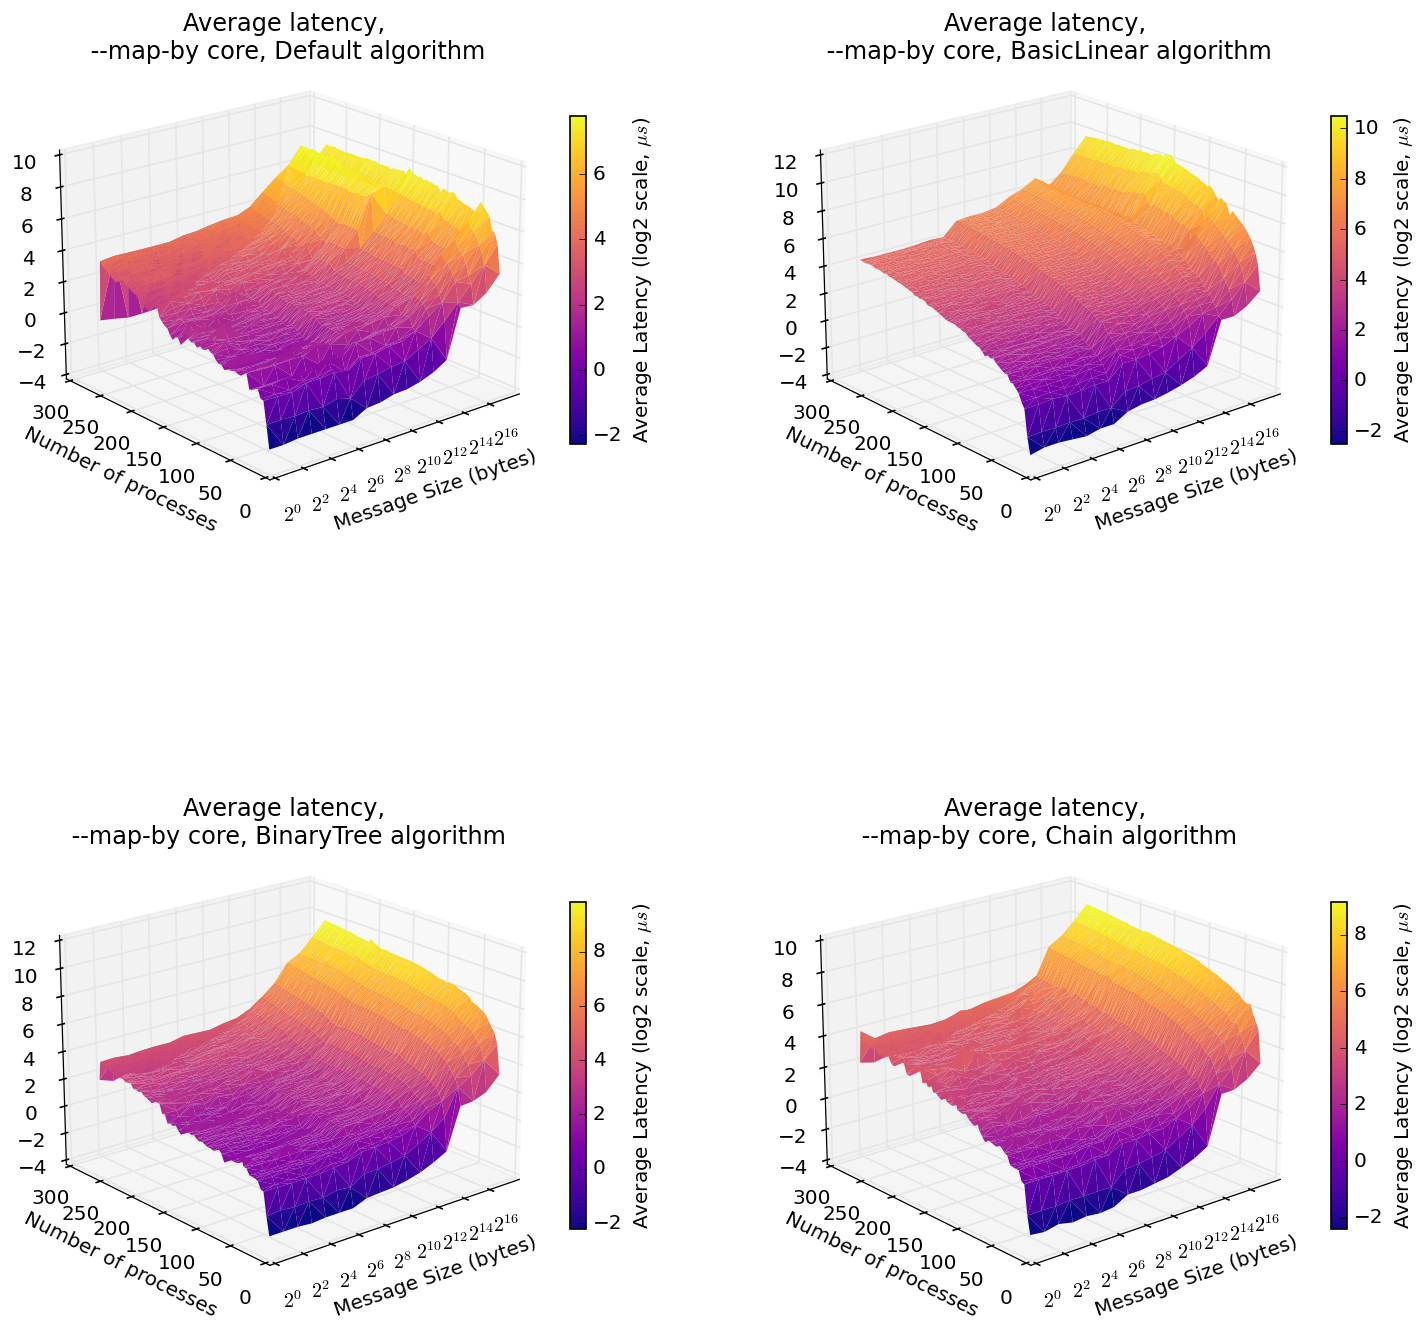

In [13]:
# Let's now fix the map allocation to --map-by core and plot some 3D heatmaps of the average latency of the
# operation against the number of processes and the message size for each algorithm to compare their general performances

def algorithm_heatmap(algorithm, plot, i, map):
    
    # Select the data for the current algorithm
    current_algorithm = bcast_results[(bcast_results.Algorithm == algorithm) & (bcast_results.Mapping == map)]
    
    # Check if the data exists
    if current_algorithm.empty:
        print(f"No data found for {algorithm}")
        return
    
    # Select the columns to plot
    x = current_algorithm["MessageSize"]
    y = current_algorithm["Processes"]
    z = current_algorithm["Latency"]
    
    # Create a 3D plot
    ax = plot.add_subplot(2, 2, i+1, projection='3d')
    
    # Plot the mesh and set the labels
    # np.log2 is used to scale the data for better visualization
    mesh = ax.plot_trisurf(np.log2(x), y, np.log2(z), cmap='plasma', edgecolor='none')
    ax.set_title(f"Average latency,\n --map-by core, {algorithm} algorithm")
    ax.set_xlabel("Message Size (bytes)")
    ax.set_ylabel("Number of processes")
    
    # Set x-axis tick labels
    xticks_labels = ['$2^{%s}$' % int(val) for val in np.log2(x.unique())]
    ax.set_xticks(np.log2(x.unique()[::2]))
    ax.set_xticklabels(xticks_labels[::2])
    
    # Add a color bar
    plot.colorbar(mesh, ax=ax, shrink=0.5, label="Average Latency (log2 scale, $\mu s$)")
    
    # Set the viewing angle of the plot
    ax.view_init(20, -130)

# Create a single figure to plot the 3D heatmaps
plot = plt.figure(figsize=(15, 15), dpi=120, facecolor='w', edgecolor='k')

algorithms = ["Default", "BasicLinear", "BinaryTree", "Chain"]

for i, algorithm in enumerate(algorithms):
    algorithm_heatmap(algorithm, plot, i, "core")
    
# Fix the layout and show the plot
plt.tight_layout()
plt.show()
    

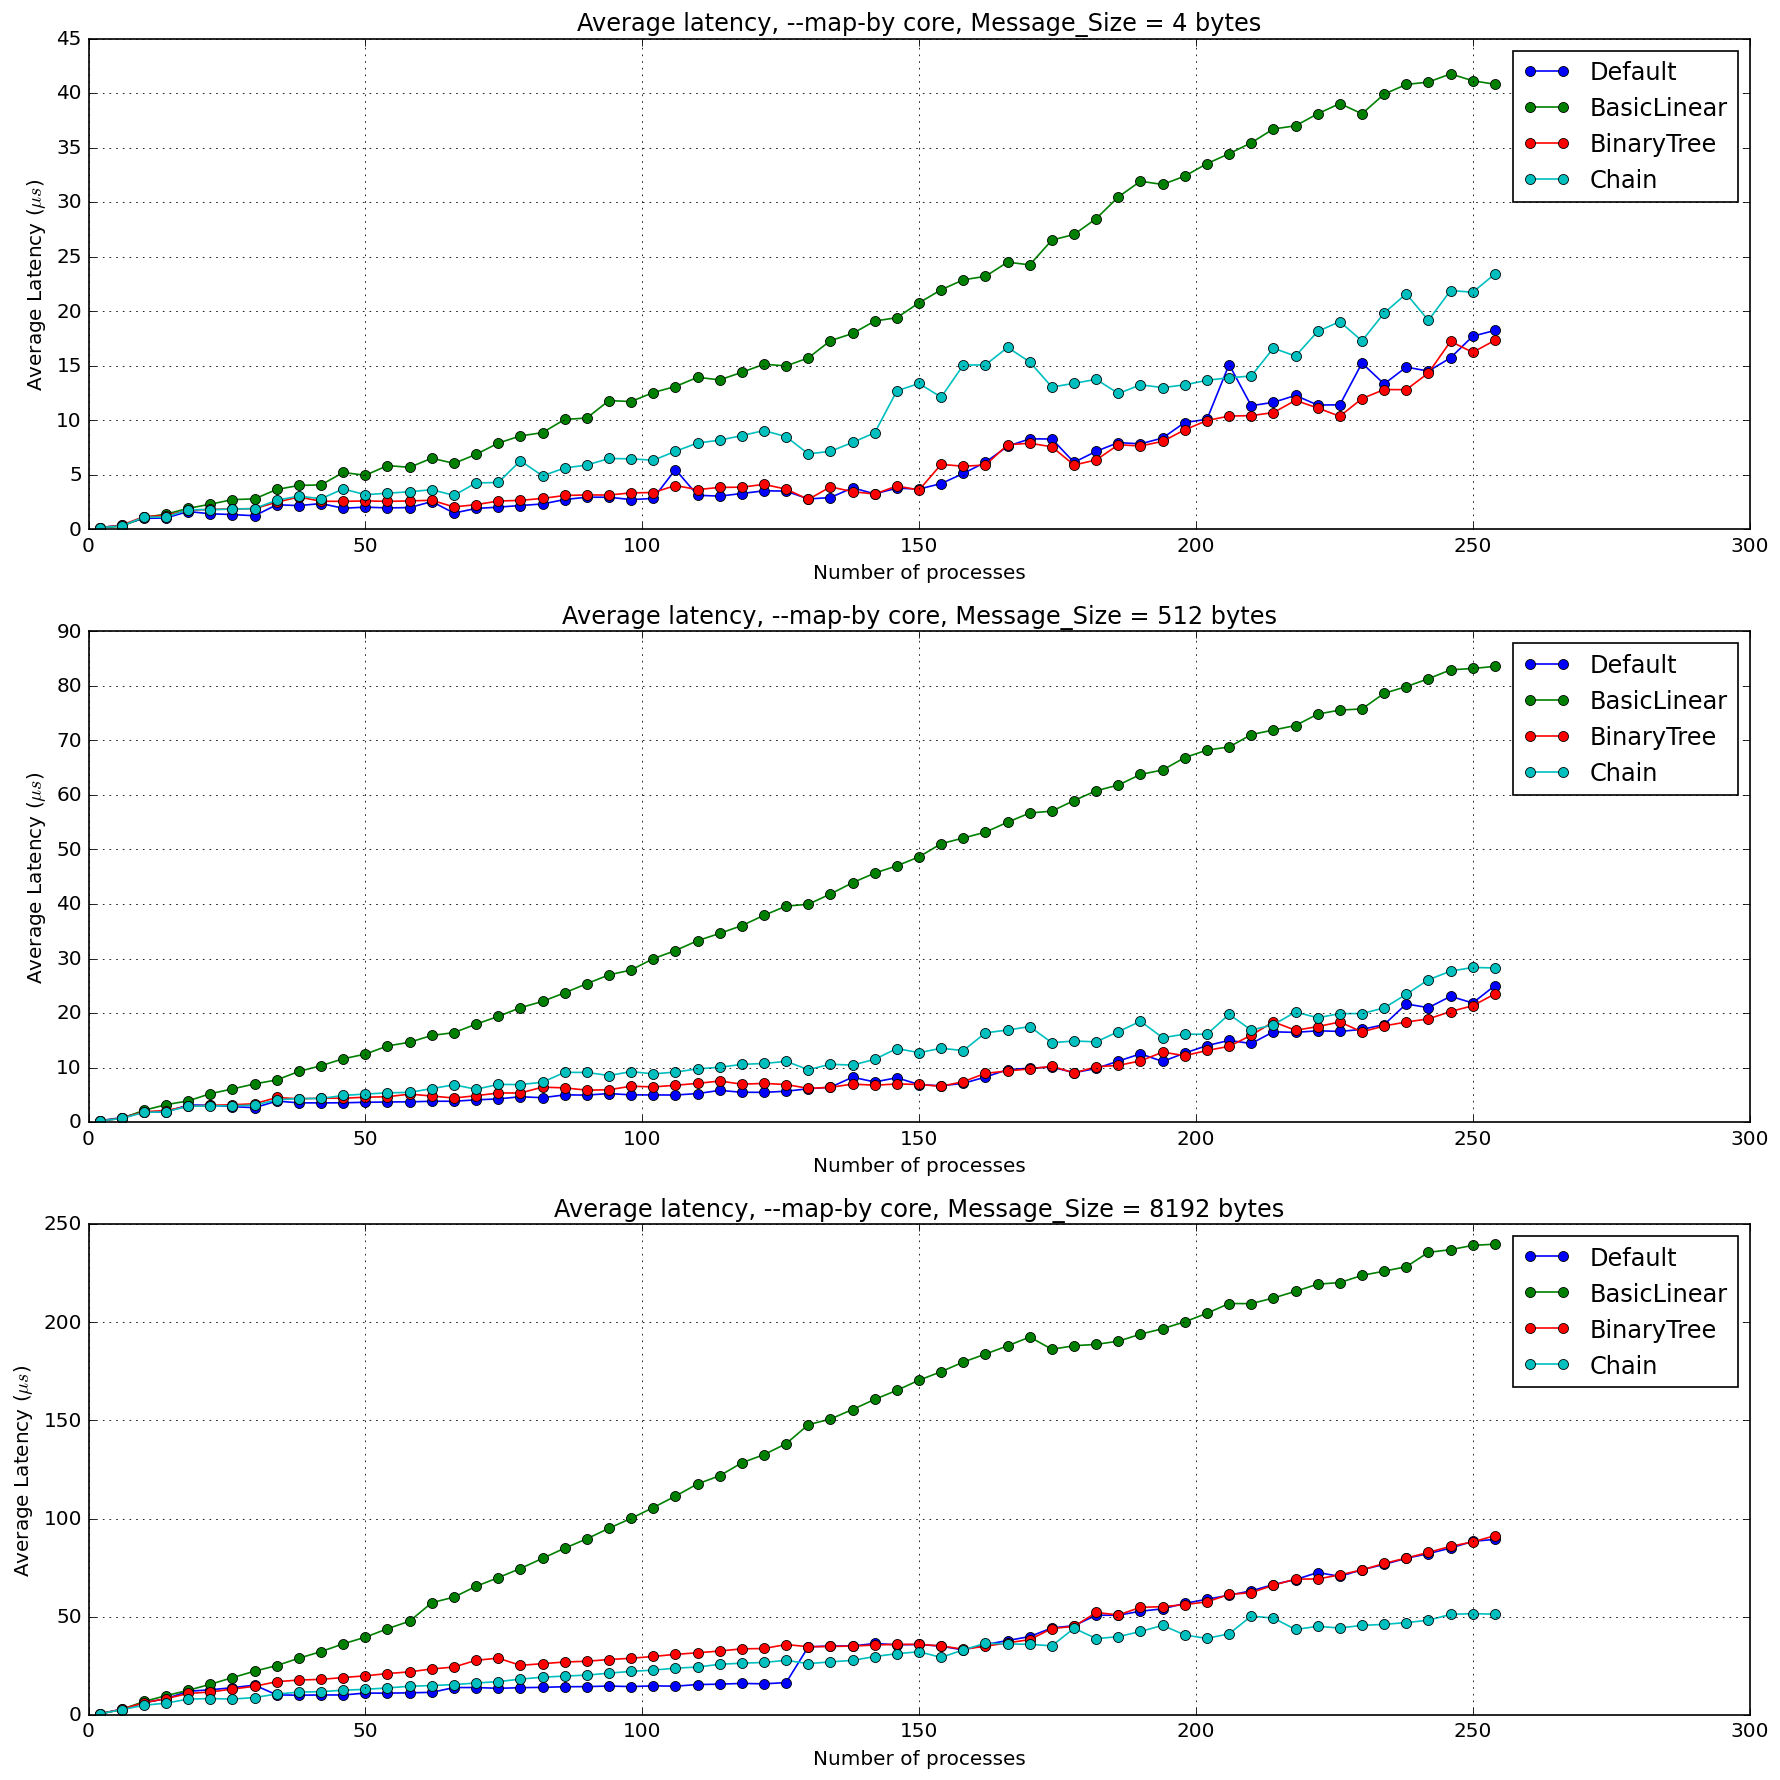

In [14]:
# After this general overview, let's now compare the algorithms by fixing the message size to three different values
# (small, medium and large) to assess the performances of the algorithms in different scenarios

# Function to plot the algorithms' average latency for different map allocations and message sizes against the number of processes
def algorithm_comparison(plot, i, message_size, map):
        
    # Select the data for the current message size
    current_message_size = bcast_results[(bcast_results.MessageSize == message_size) & (bcast_results.Processes != 256)]
        
    # Check if the data exists
    if current_message_size.empty:
        print(f"No data found for message size {message_size}")
        return
        
    # Select the columns to plot
    x = current_message_size["Processes"].unique()
    y_default = current_message_size[((current_message_size.Algorithm == "Default") & (current_message_size.Mapping == map))]["Latency"]
    y_basiclinear = current_message_size[((current_message_size.Algorithm == "BasicLinear") & (current_message_size.Mapping == map))]["Latency"]
    y_binarytree = current_message_size[((current_message_size.Algorithm == "BinaryTree") & (current_message_size.Mapping == map))]["Latency"]
    y_chain = current_message_size[((current_message_size.Algorithm == "Chain") & (current_message_size.Mapping == map))]["Latency"]
        
    # Create a 2D plot
    ax = plot.add_subplot(3, 1, i+1)
        
    # Plot the data and set the labels
    ax.plot(x, y_default, label="Default", marker="o")
    ax.plot(x, y_basiclinear, label="BasicLinear", marker="o")
    ax.plot(x, y_binarytree, label="BinaryTree", marker="o")
    ax.plot(x, y_chain, label="Chain", marker="o")
    ax.set_title(f"Average latency, --map-by {map}, Message_Size = {message_size} bytes")
    ax.set_xlabel("Number of processes")
    ax.set_ylabel("Average Latency ($\mu s$)")
    ax.legend()
    plt.grid(True)

# Create a single figure to plot the results
plt.style.use("classic")
plot = plt.figure(figsize=(15, 15), dpi=120, facecolor='w', edgecolor='k')

# Define the message sizes to plot
message_sizes = [4, 512, 8192]

# Plot the data for each message size and core allocation
for i, message_size in enumerate(message_sizes):
    algorithm_comparison(plot, i, message_size, "core")

# Fix the layout and show the plot
plt.tight_layout()
plt.show()


In [15]:
# We can compare the performances of the algorithms; moreover, we can see that the average latency increases with the
# number of processes and the message size

# A note on the map allocation: here we focused on the --map-by core allocation, because from the collected data that 
# was the one that in general provided the lowest average latency. In fact, the --map-by socket allocation provided
# higher average latencies for the same message size and number of processes

In [16]:
# Let's now try to build a model to predict the average latency of the broadcast operation based on the number of processes
# and the message size. I will use a linear regression model to predict the average latency of the broadcast operation, building
# a model for each algorithm.

# Function to build a linear regression model for the average latency of the broadcast operation
def build_model(algorithm, map):
    
    # Select the data for the current algorithm
    current_algorithm = bcast_results[(bcast_results.Algorithm == algorithm) & (bcast_results.Mapping == map)]
    
    # Check if the data exists
    if current_algorithm.empty:
        print(f"No data found for {algorithm}")
        return
    
    # Select as response variable the log2 of the average latency
    y = np.log2(current_algorithm["Latency"])
    
    # Select as predictors the the number of processes and the log2 of the message size
    # We don't insert the intercept in the model, since the average latency should be 0 when the number of processes and the
    # message size are 0
    x = current_algorithm[["Processes", "MessageSize"]]
    x["MessageSize"] = np.log2(x["MessageSize"])
    
    # Note: the log2 of the message size and the average latency are used consistently with the plots above, where the average
    # latency was plotted on a log2 scale and the message size was plotted on a log2 scale as well. In fact, plotting the histograms
    # of the average latency and the message size showed skewed distributions, so the use of the log2 scale is consistent with the
    # data distribution. Moreover, the use of the log2 scale greatly improves the performance of the model
    
    # Try to add as predictor the log2 of the square of the message size, since the plots above showed a quadratic dependency of
    # the average latency on the message size
    x["MessageSize^2"] = x["MessageSize"]**2
    # It improved the model's performance, so I will keep it
    
    # Build the model
    return sm.OLS(y, x).fit()

# Build the model for the default algorithm and the core allocation
model_default = build_model("Default", "core")

# Print the summary of the model
print(f"Model for Default algorithm, --map-by core allocation")
print(model_default.summary())
print("\n")

Model for Default algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.273e+04
Date:                Sat, 30 Mar 2024   Prob (F-statistic):                        0.00
Time:                        23:58:32   Log-Likelihood:                         -1248.6
No. Observations:                1170   AIC:                                      2503.
Df Residuals:                    1167   BIC:                                      2518.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.

/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize"] = np.log2(x["MessageSize"])
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize^2"] = x["MessageSize"]**2


In [17]:
# Build the model for the basic linear algorithm and the core allocation
model_basiclinear = build_model("BasicLinear", "core")

# Print the summary of the model
print(f"Model for BasicLinear algorithm, --map-by core allocation")
print(model_basiclinear.summary())
print("\n")

Model for BasicLinear algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.275e+04
Date:                Sat, 30 Mar 2024   Prob (F-statistic):                        0.00
Time:                        23:58:32   Log-Likelihood:                         -1646.4
No. Observations:                1170   AIC:                                      3299.
Df Residuals:                    1167   BIC:                                      3314.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|     

/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize"] = np.log2(x["MessageSize"])
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize^2"] = x["MessageSize"]**2


In [18]:
# Build the model for the binary tree algorithm and the core allocation
model_binarytree = build_model("BinaryTree", "core")

# Print the summary of the model
print(f"Model for BinaryTree algorithm, --map-by core allocation")
print(model_binarytree.summary())
print("\n")

Model for BinaryTree algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          1.836e+04
Date:                Sat, 30 Mar 2024   Prob (F-statistic):                        0.00
Time:                        23:58:32   Log-Likelihood:                         -1176.8
No. Observations:                1170   AIC:                                      2360.
Df Residuals:                    1167   BIC:                                      2375.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      

/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize"] = np.log2(x["MessageSize"])
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize^2"] = x["MessageSize"]**2


In [19]:
# Build the model for the chain algorithm and the core allocation
model_chain = build_model("Chain", "core")

# Print the summary of the model
print(f"Model for Chain algorithm, --map-by core allocation")
print(model_chain.summary())
print("\n")

Model for Chain algorithm, --map-by core allocation
                                 OLS Regression Results                                
Dep. Variable:                Latency   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          1.227e+04
Date:                Sat, 30 Mar 2024   Prob (F-statistic):                        0.00
Time:                        23:58:32   Log-Likelihood:                         -1410.4
No. Observations:                1170   AIC:                                      2827.
Df Residuals:                    1167   BIC:                                      2842.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.02

/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize"] = np.log2(x["MessageSize"])
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/3533431911.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["MessageSize^2"] = x["MessageSize"]**2


/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/2810442877.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_pred = model.params[0]*y_pred + model.params[1]*x_pred + model.params[2]*x_pred**2
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/2810442877.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  z_pred = model.params[0]*y_pred + model.params[1]*x_pred + model.params[2]*x_pred**2
/var/folders/n1/qzz0lld55r7fsyrn_h1l51mm0000gn/T/ipykernel_56747/2810442877.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

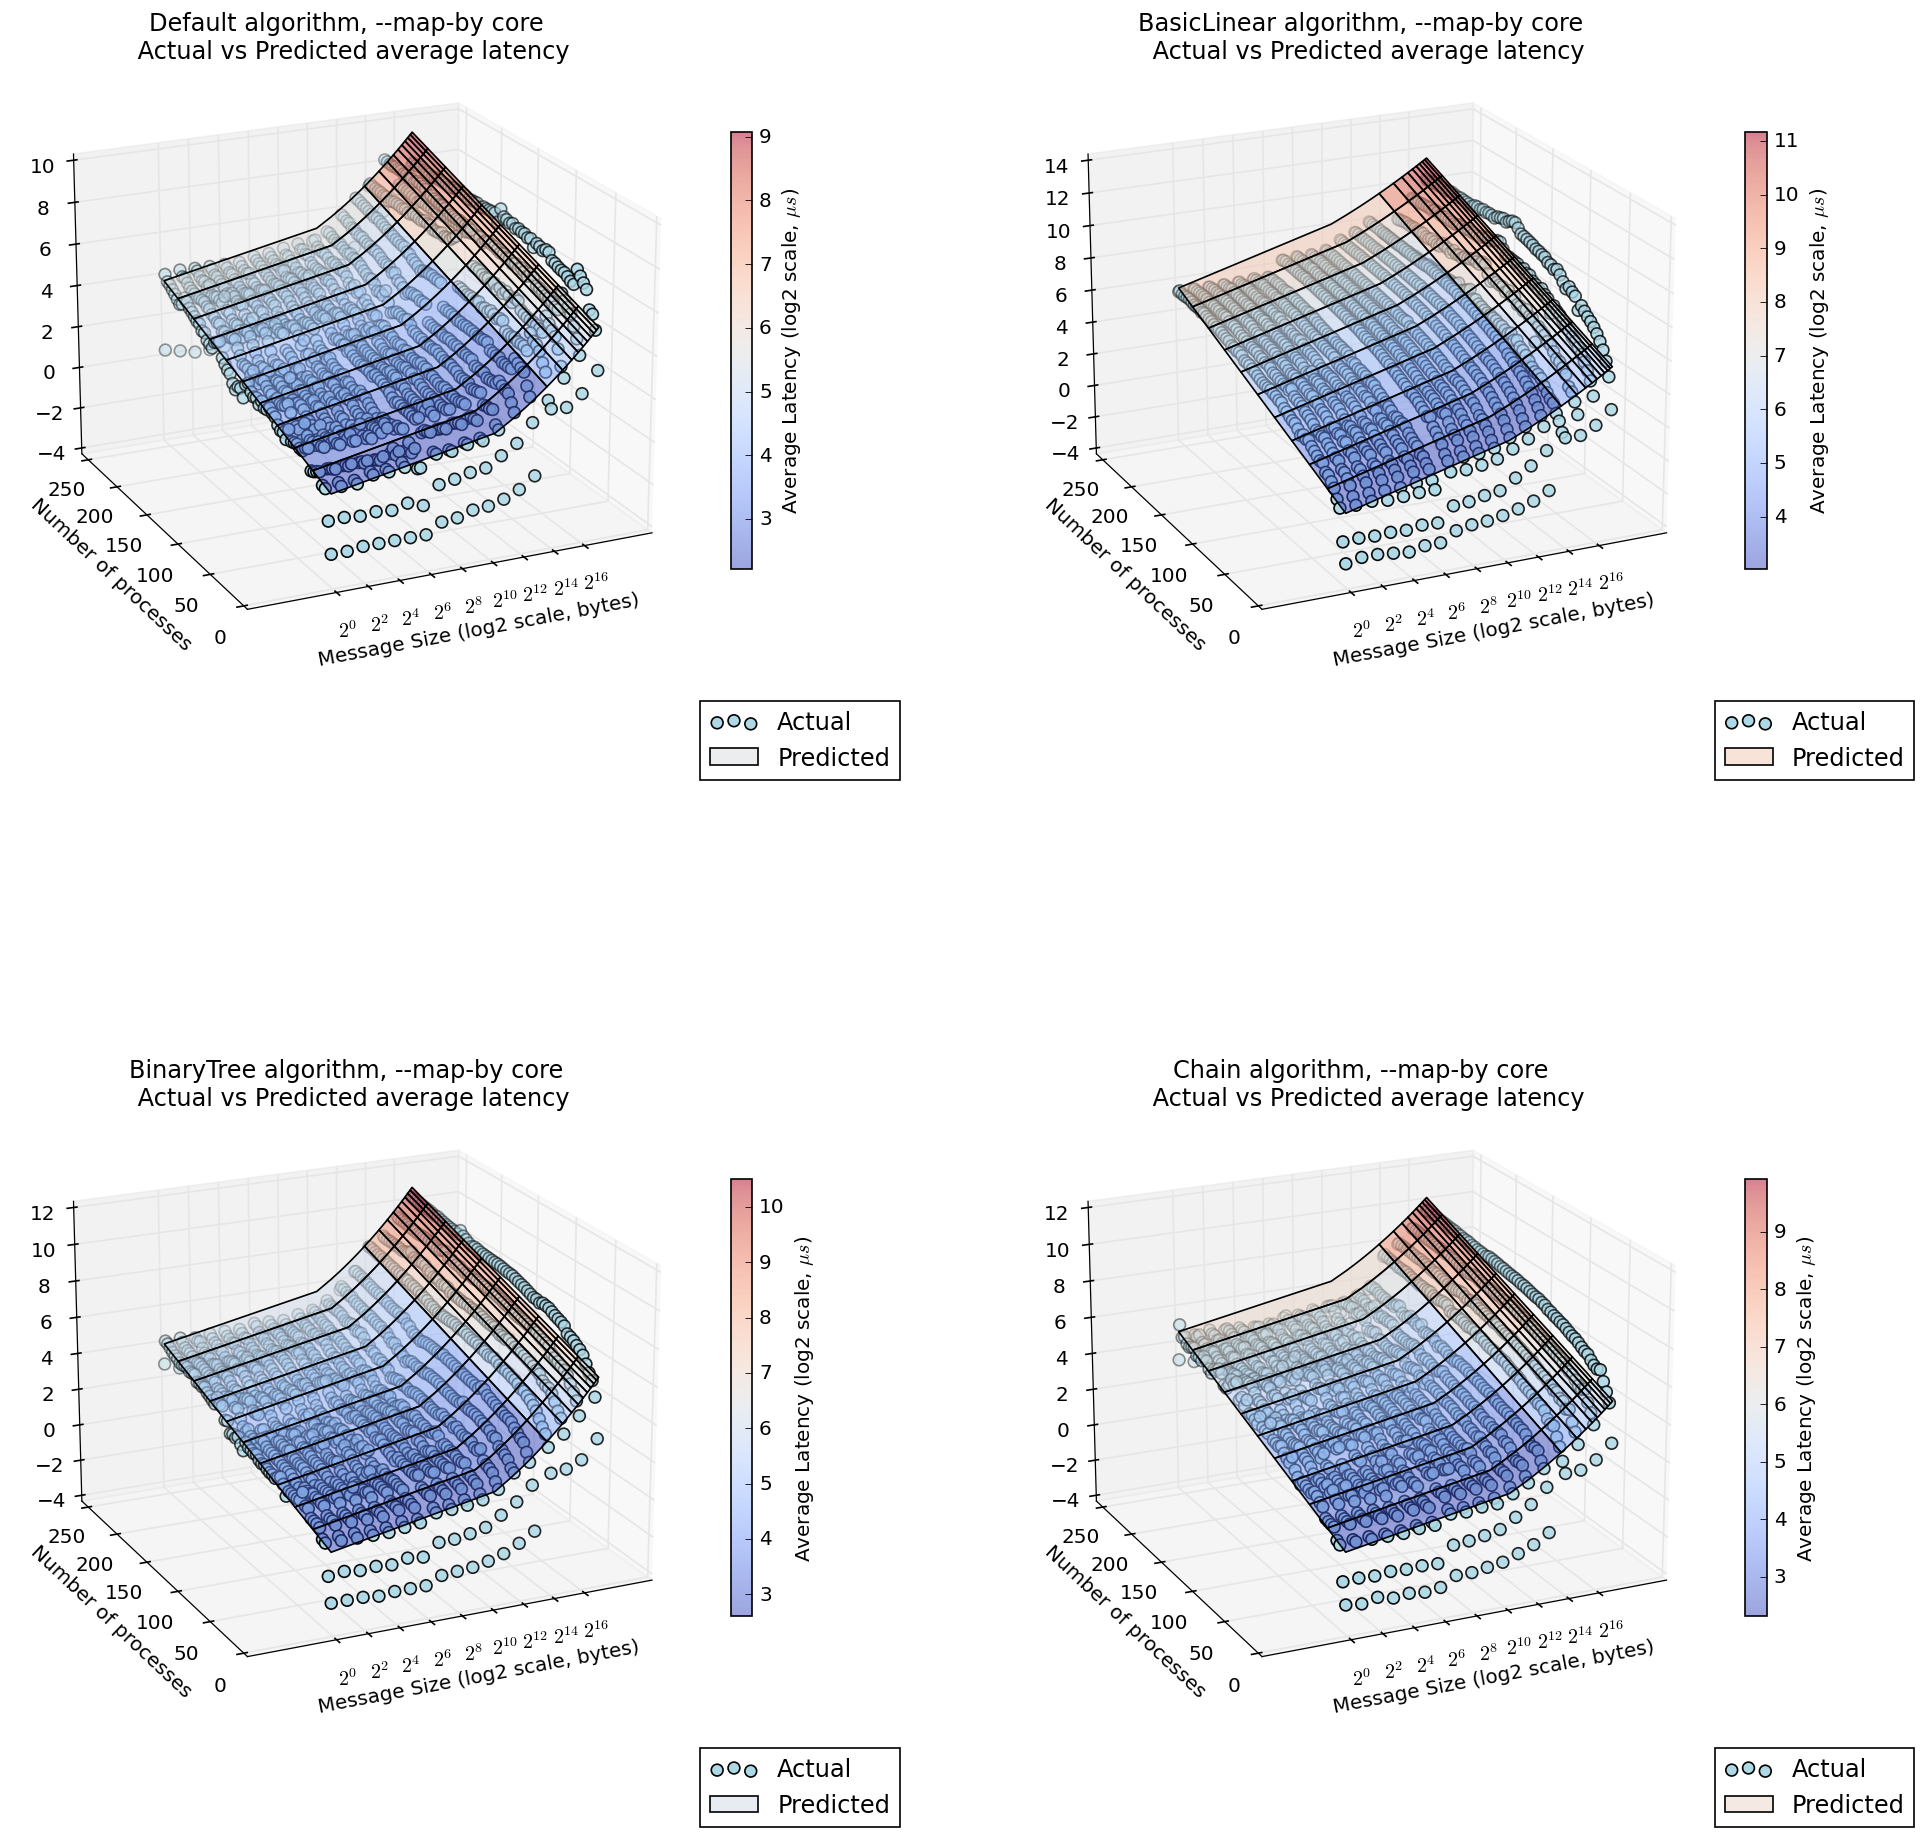

In [20]:
# Let's plot some 3D plots to visualize the models: I'll do 4 plots, one for each algorithm, where the average latency
# is plotted against the number of processes and the message size. I'll plot the actual average latency with scatter plots
# and the predicted average latency with a surface plot.

# Function to plot the models
def plot_model(plot, model, algorithm, map, i):
    
    # Select the data for the current algorithm
    current_algorithm = bcast_results[(bcast_results.Algorithm == algorithm) & (bcast_results.Mapping == map)]
    
    # Check if the data exists
    if current_algorithm.empty:
        print(f"No data found for {algorithm}")
        return
    
    # Select the columns to plot
    x = current_algorithm["MessageSize"]
    y = current_algorithm["Processes"]
    z = current_algorithm["Latency"]
    
    # Create a 3D plot
    ax = plot.add_subplot(2, 2, i+1, projection='3d')
    
    # Plot the actual average latency
    ax.scatter(np.log2(x), y, np.log2(z), c='lightblue', marker='o', s = 50 ,label="Actual")
    
    # Plot the predicted average latency
    x_pred = np.log2(np.linspace(x.min(), x.max(), 100))
    y_pred = np.linspace(y.min(), y.max(), 100)
    x_pred, y_pred = np.meshgrid(x_pred, y_pred)
    z_pred = model.params[0]*y_pred + model.params[1]*x_pred + model.params[2]*x_pred**2
    surf = ax.plot_surface(x_pred, y_pred, z_pred, cmap=cm.coolwarm, alpha=0.5, label="Predicted")
    
    # Add a colorbar
    plot.colorbar(surf, shrink=0.5, ax=ax, label="Average Latency (log2 scale, $\mu s$)")
    
    # Set the labels
    ax.set_title(f"{algorithm} algorithm, --map-by {map} \n Actual vs Predicted average latency")
    ax.set_xlabel("Message Size (log2 scale, bytes)")
    ax.set_ylabel("Number of processes")
    ax.legend()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0))
    
    # Set x-axis tick labels
    xticks_labels = ['$2^{%s}$' % int(val) for val in np.log2(x.unique())]
    ax.set_xticks(np.log2(x.unique()[::2]))
    ax.set_xticklabels(xticks_labels[::2])
    
    # Set the y-axis to start from 0
    ax.set_ylim([0, y.max()]) 

    # Set the viewing angle of the plot
    ax.view_init(20, -115)

# Create a single figure to plot the 3D plots
plot = plt.figure(figsize=(20, 20), dpi=120, facecolor='w', edgecolor='k')

# Plot the models for each algorithm
plot_model(plot, model_default, "Default", "core", 0)
plot_model(plot, model_basiclinear, "BasicLinear", "core", 1)
plot_model(plot, model_binarytree, "BinaryTree", "core", 2)
plot_model(plot, model_chain, "Chain", "core", 3)

# Fix the layout and show the plot
plt.tight_layout()
plt.show()